# ATLAS/ICESat-02 ATL08 Access and Visualize

Author: Sumant Jha (MSFC/USRA), Alex Mandel (DevSeed), Jamison French (DevSeed), Rajat Shinde (UAH), Sheyenne Kirkland (UAH)

Date: March 4, 2024

Description: In this example, we'll walk through two methods accessing ATL08 data from the NSIDC DAAC S3 and NASA's Earthdata search using `maap-py`. We'll then explore the data using `H5py`, `h5Glance`, and `xarray`. Finally, we'll visualize some of the data using `xarray`.

## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: This tutorial will use an experimental feature to allow access to the DAAC without using EarthDataLogin. This tutorial will need to be ran within MAAP's ADE to allow this experimental feature to work. Running the tutorial outside of the MAAP ADE will result in errors.

## About the Data

This data set (ATL08) contains along-track heights above the WGS84 ellipsoid (ITRF2014 reference frame) for the ground and canopy surfaces. The canopy and ground surfaces are processed in fixed 100 m data segments, which typically contain more than 100 signal photons. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.

```
Parameter(s): TERRAIN ELEVATION
Platform(s):ICESat-2
Sensor(s): ATLAS
Data Format(s): HDF5
Temporal Coverage: 14 October 2018 to present
Temporal Resolution: 91 day
Spatial Resolution: Varies
Spatial Reference System(s): WGS 84 EPSG:4326
Spatial Coverage: N: 90 S: -90 E: 180 W: -180
```

(Source: [ATL08 v6 Dataset Landing Page](https://nsidc.org/data/atl08/versions/5))


## Additional Resources
- [Earthdata Search](https://search.earthdata.nasa.gov/search?q=atl08&ff=Available%20in%20Earthdata%20Cloud)
- [ATL08 v6 User Guide](https://nsidc.org/sites/default/files/documents/user-guide/atl08-v006-userguide.pdf)

## Importing and Installing Packages

The following example uses several packages. If you do not have the following packages, uncomment the code below:

In [22]:
# !pip install -q h5py h5glance requests rioxarray fsspec s3fs h5netcdf

In [23]:
import os
import h5py
from maap.maap import MAAP
from h5glance import H5Glance
import requests
import xarray
import boto3
import fsspec

## Accessing the Data

In this section we'll walk through two different ways to access the data. The first method is to access the data through S3.

The second method is to access it by using `maap-py`, then download the data locally. From there, we will explore some of the data using `h5glance`.

### Example 1: Accessing the Data with S3

We will use role assumption to gain access to the data. To do this, we'll use an experimental feature by setting up a parameter, assuming a role, and get temporary credentials with the assumed role. We'll also set up credentials into fsspec so we can later use `xarray` for data exploration.

In [24]:
def assume_role_credentials(ssm_parameter_name):
    # Create a session using your current credentials
    session = boto3.Session()

    # Retrieve the SSM parameter
    ssm = session.client('ssm', "us-west-2")
    parameter = ssm.get_parameter(
        Name=ssm_parameter_name, 
        WithDecryption=True
    )
    parameter_value = parameter['Parameter']['Value']

    # Assume the DAAC access role
    sts = session.client('sts')
    assumed_role_object = sts.assume_role(
        RoleArn=parameter_value,
        RoleSessionName='TutorialSession'
    )

    # From the response that contains the assumed role, get the temporary 
    # credentials that can be used to make subsequent API calls
    credentials = assumed_role_object['Credentials']

    return credentials

def fsspec_access(credentials):
    # Pass assumed role credentials into fsspec
    return fsspec.filesystem(
        "s3",
        key=credentials['AccessKeyId'],
        secret=credentials['SecretAccessKey'],
        token=credentials['SessionToken']
    )

In [25]:
s3_fsspec = fsspec_access(assume_role_credentials("/iam/maap-data-reader"))

### Example 2: Download Data Locally

We are going to use NASA host which is NASA's Common Metadata Repository (CMR) to search for and download ICESat data. 
ICESat's ATL08 data's concept id can be found on https://search.earthdata.nasa.gov/search and looking for 'ATL08' in the search bar. When you check the metadata associated with your search result, you can get the concept_id associated with below tutorial. In this case, the concept_id is `C2613553260-NSIDC_CPRD`.  

For this example, we are going to use granule id of `ATL08_20230816182927_08792008_006_01.h5`. This will be in HDF5 format. 

With all this information in hand, we are ready to make a query to cmr.earthdata.nasa.gov using `maap-py`. 


In [26]:
maap = MAAP(maap_host='api.maap-project.org')

nasa_host = "cmr.earthdata.nasa.gov"
results = maap.searchGranule(cmr_host=nasa_host,
                             concept_id="C2613553260-NSIDC_CPRD",
                             readable_granule_name="ATL08_20230816182927_08792008_006_01.h5")

Let's see how this turned out. Did we get a result?

In [27]:
results[0]

{'concept-id': 'G2800397933-NSIDC_CPRD',
 'collection-concept-id': 'C2613553260-NSIDC_CPRD',
 'revision-id': '2',
 'format': 'application/echo10+xml',
 'Granule': {'GranuleUR': 'ATL08_20230816182927_08792008_006_01.h5',
  'InsertTime': '2023-11-11T10:14:36.642Z',
  'LastUpdate': '2023-11-11T10:14:36.642Z',
  'Collection': {'DataSetId': 'ATLAS/ICESat-2 L3A Land and Vegetation Height V006'},
  'DataGranule': {'SizeMBDataGranule': '106.29328060150146',
   'ProducerGranuleId': 'ATL08_20230816182927_08792008_006_01.h5',
   'DayNightFlag': 'UNSPECIFIED',
   'ProductionDateTime': '2023-09-21T19:57:30.000Z'},
  'Temporal': {'RangeDateTime': {'BeginningDateTime': '2023-08-16T18:29:24.813Z',
    'EndingDateTime': '2023-08-16T18:36:27.524Z'}},
  'Spatial': {'HorizontalSpatialDomain': {'Geometry': {'GPolygon': {'Boundary': {'Point': [{'PointLongitude': '-49.71155',
         'PointLatitude': '-0.55384'},
        {'PointLongitude': '-51.21715', 'PointLatitude': '-15.49643'},
        {'PointLongitude

Looks like we did get a result and will be able to learn a lot about it from available metadata. Let's download the HDF file locally.

In [28]:
s3_url = results[0]['Granule']['OnlineAccessURLs']['OnlineAccessURL'][1]['URL']
s3_url

's3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2023/08/16/ATL08_20230816182927_08792008_006_01.h5'

In [29]:
data_file = results[0]

Establish a temporary directory to store the data file and display the path and filename. 

In [30]:
dataDir = './data'
if not os.path.exists(dataDir): os.mkdir(dataDir)
data = data_file.getData(dataDir)
data

'./data/ATL08_20230816182927_08792008_006_01.h5'

## Exploring the Data

There are two different ways we'll open and look at the data:
1. Using `xarray`
2. Using `h5py`

### 1. xarray

By using `xarray`, we can open a specific group within the HDF5 file.

In [33]:
nsidc_object = s3_url
with s3_fsspec.open(nsidc_object) as f:
    atl08_track = xarray.open_dataset(f, group='gt1l/land_segments', engine="h5netcdf", phony_dims='sort')
atl08_track

<xarray.Dataset>
Dimensions:            (delta_time: 18690, ds_geosegments: 5, ds_surf_type: 5)
Coordinates:
  * delta_time         (delta_time) datetime64[ns] 2023-08-16T18:29:24.853128...
    latitude           (delta_time) float32 ...
    longitude          (delta_time) float32 ...
Dimensions without coordinates: ds_geosegments, ds_surf_type
Data variables: (12/41)
    asr                (delta_time) float32 ...
    atlas_pa           (delta_time) float32 ...
    beam_azimuth       (delta_time) float32 ...
    beam_coelev        (delta_time) float32 ...
    brightness_flag    (delta_time) float32 ...
    cloud_flag_atm     (delta_time) float32 ...
    ...                 ...
    snr                (delta_time) float32 ...
    solar_azimuth      (delta_time) float32 ...
    solar_elevation    (delta_time) float32 ...
    surf_type          (delta_time, ds_surf_type) int8 ...
    terrain_flg        (delta_time) float64 ...
    urban_flag         (delta_time) float64 ...
Attributes:
    Description:  Contains data categorized as land at 100 meter intervals.
    data_rate:    Data are stored as aggregates of 100 meters.

### 2. H5py and H5glance

Let's check the available keys and structure of the HDF5 files using `H5py` and `H5glance`. 

Open the file and list the keys:

In [31]:
atl08_file = h5py.File(data,'r')
list(atl08_file.keys())

['METADATA',
 'ancillary_data',
 'ds_geosegments',
 'ds_metrics',
 'ds_surf_type',
 'gt1l',
 'gt1r',
 'gt2l',
 'gt2r',
 'gt3l',
 'gt3r',
 'orbit_info',
 'quality_assessment']

Use `H5glance` module to interactively check all available variables and field that can be used for further analysis and visualizations.

In [32]:
H5Glance(atl08_file)

./data/ATL08_20230816182927_08792008_006_01.h5/ (47 attributes)
├METADATA	(9 children) (3 attributes)
├ancillary_data	(26 children) (2 attributes)
├ds_geosegments	[int8: 5] (12 attributes)
├ds_metrics	[int8: 18] (12 attributes)
├ds_surf_type	[int32: 5] (12 attributes)
├gt1l	(2 children) (7 attributes)
├gt1r	(2 children) (7 attributes)
├gt2l	(2 children) (7 attributes)
├gt2r	(2 children) (7 attributes)
├gt3l	(2 children) (7 attributes)
├gt3r	(2 children) (7 attributes)
├orbit_info	(9 children) (2 attributes)
└quality_assessment	(2 children) (1 attributes)

## Visualizing the Data

By looking at the data variables, we can also create a visualization using `xarray`. Let's plot elevation:

<xarray.Dataset>
Dimensions:            (delta_time: 18690, ds_geosegments: 5, ds_surf_type: 5)
Coordinates:
  * delta_time         (delta_time) datetime64[ns] 2023-08-16T18:29:24.853128...
    latitude           (delta_time) float32 ...
    longitude          (delta_time) float32 ...
Dimensions without coordinates: ds_geosegments, ds_surf_type
Data variables: (12/41)
    asr                (delta_time) float32 ...
    atlas_pa           (delta_time) float32 ...
    beam_azimuth       (delta_time) float32 ...
    beam_coelev        (delta_time) float32 ...
    brightness_flag    (delta_time) float32 ...
    cloud_flag_atm     (delta_time) float32 ...
    ...                 ...
    snr                (delta_time) float32 ...
    solar_azimuth      (delta_time) float32 ...
    solar_elevation    (delta_time) float32 ...
    surf_type          (delta_time, ds_surf_type) int8 ...
    terrain_flg        (delta_time) float64 ...
    urban_flag         (delta_time) float64 ...
Attributes:
  

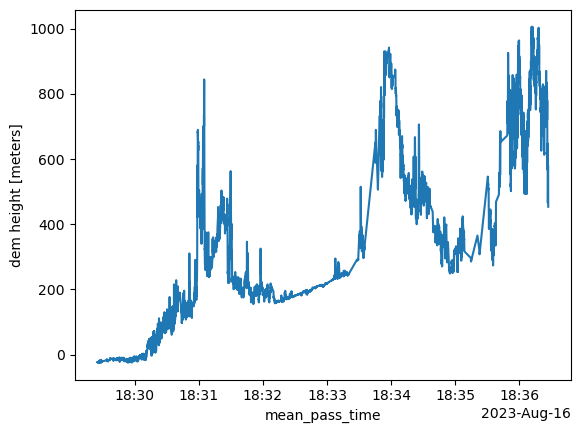

In [34]:
with s3_fsspec.open(nsidc_object) as f:
    with xarray.open_dataset(f, group='gt1l/land_segments', engine="h5netcdf", phony_dims='sort') as atl08_track:
        print(atl08_track)
        atl08_track.dem_h.plot()

If we want to plot canopy height, we can also do that:

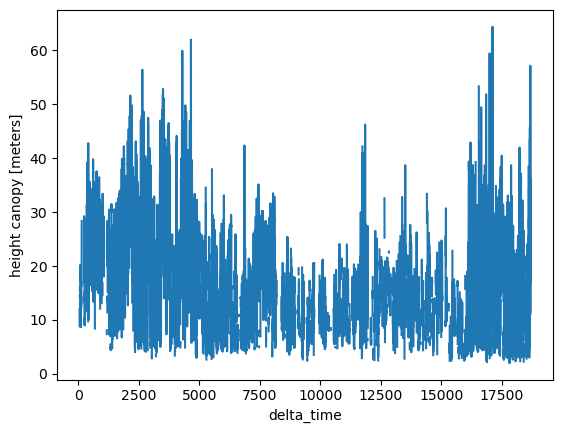

In [35]:
with s3_fsspec.open(nsidc_object) as f:
    with xarray.open_dataset(f, group='gt1l/land_segments/canopy', engine="h5netcdf", phony_dims='sort') as atl08_track:
        atl08_track.h_canopy.plot()